<a href="https://colab.research.google.com/github/Piyali04/brain_tumour/blob/main/BRAIN_TUMOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive

MyDrive  Shareddrives


In [ ]:
import zipfile
import os

# List of zip file paths (Make sure these are correctly named)
zip_paths = [
    '/content/drive/MyDrive/brain_tumour/training/glioma/glioma-20250408T201003Z-001.zip',
    '/content/drive/MyDrive/brain_tumour/training/meningioma/meningioma-20250408T201344Z-001.zip',
    '/content/drive/MyDrive/brain_tumour/training/notumor/notumor-20250408T201736Z-001.zip',
    '/content/drive/MyDrive/brain_tumour/training/pituitary/pituitary-20250408T201910Z-001.zip'
]

# Matching extract directories — use consistent names (no space in folder names)
extract_dirs = [
    '/content/brain_tumor/glioma',
    '/content/brain_tumor/meningioma',
    '/content/brain_tumor/notumor',
    '/content/brain_tumor/pituitary'
]

# Unzip each file to its corresponding directory
for zip_file, extract_to in zip(zip_paths, extract_dirs):
    try:
        print(f"📦 Extracting {zip_file} → {extract_to}")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("✅ Done\n")
    except Exception as e:
        print(f"❌ Error extracting {zip_file}: {e}\n")


📦 Extracting /content/drive/MyDrive/brain_tumour/training/glioma/glioma-20250408T201003Z-001.zip → /content/brain_tumor/glioma
✅ Done

📦 Extracting /content/drive/MyDrive/brain_tumour/training/meningioma/meningioma-20250408T201344Z-001.zip → /content/brain_tumor/meningioma
✅ Done

📦 Extracting /content/drive/MyDrive/brain_tumour/training/notumor/notumor-20250408T201736Z-001.zip → /content/brain_tumor/notumor
✅ Done

📦 Extracting /content/drive/MyDrive/brain_tumour/training/pituitary/pituitary-20250408T201910Z-001.zip → /content/brain_tumor/pituitary
✅ Done



Looking in: /content/brain_tumor/glioma/glioma
Looking in: /content/brain_tumor/meningioma/meningioma
Looking in: /content/brain_tumor/notumor/notumor
Looking in: /content/brain_tumor/pituitary/pituitary


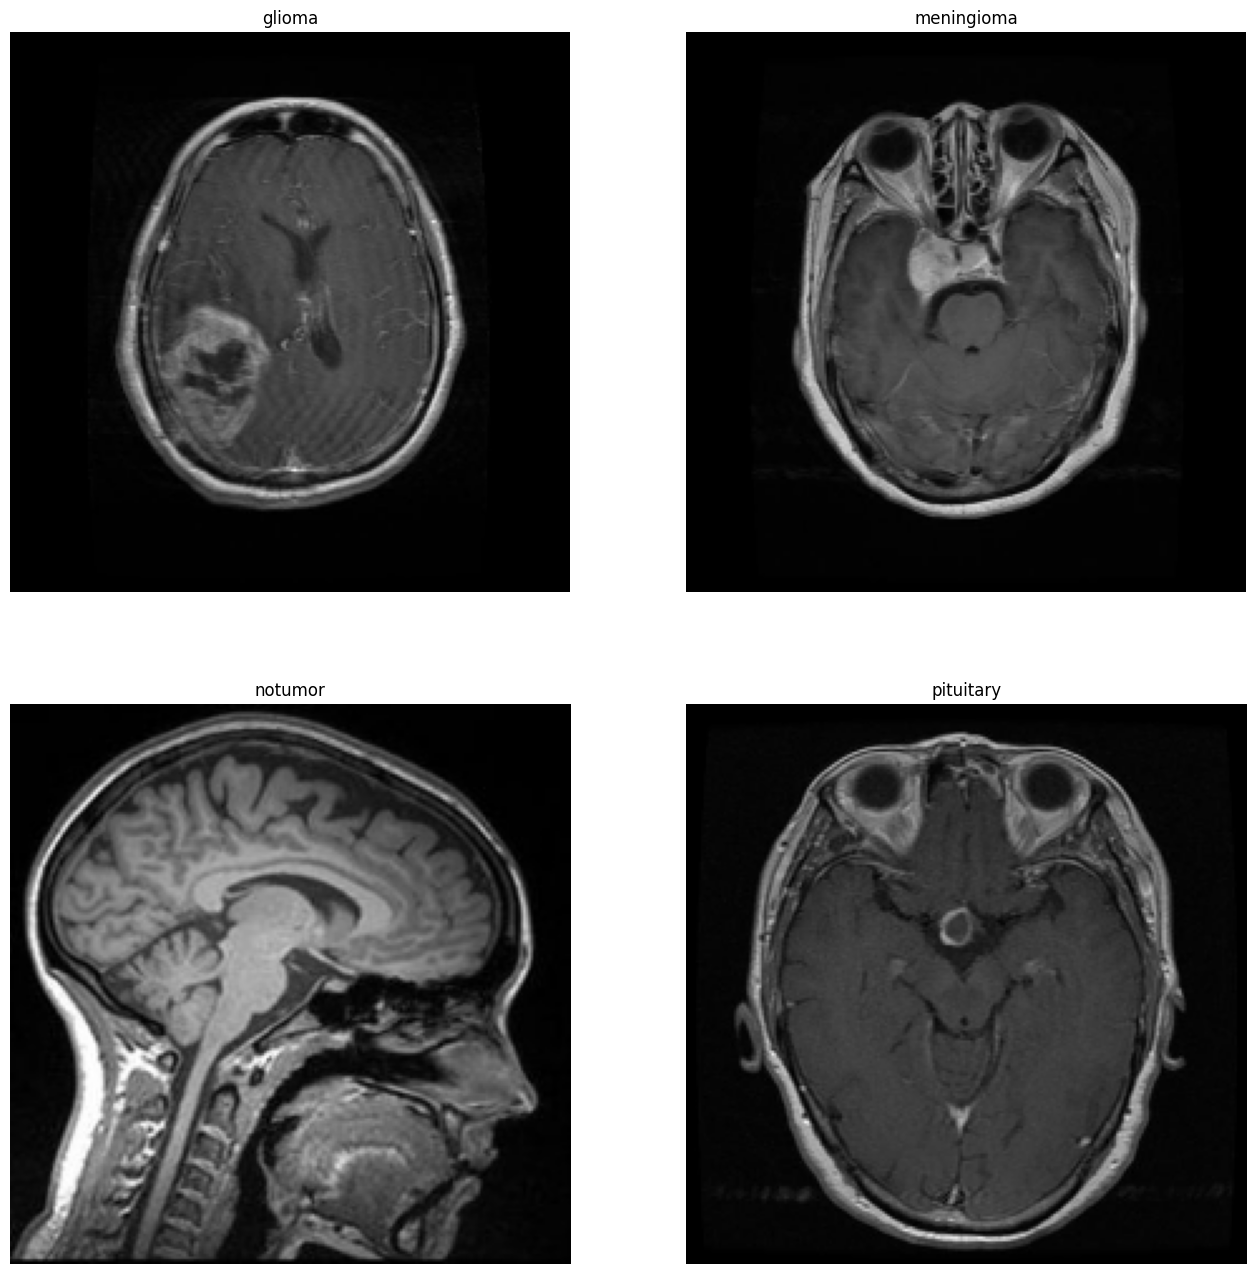

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
base_dir = '/content/brain_tumor'
images_path = []

# Step 1: Go deeper into each folder and grab the first image
for category in categories:
    inner_dir = os.path.join(base_dir, category, category)  # e.g., /content/brain_tumor/glioma/glioma
    print(f"Looking in: {inner_dir}")

    if os.path.exists(inner_dir):
        files = os.listdir(inner_dir)
        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]
        if image_files:
            images_path.append(os.path.join(inner_dir, image_files[0]))  # Pick the first image
        else:
            print(f"⚠️ No image files found in {inner_dir}")
            images_path.append(None)
    else:
        print(f"❌ Folder not found: {inner_dir}")
        images_path.append(None)

# Step 2: Plot the images
plt.figure(figsize=(16, 16))
for i in range(4):
    img_path = images_path[i]
    if img_path is None:
        print(f"⚠️ Skipping missing image for category: {categories[i]}")
        continue
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Failed to read image at: {img_path}")
        continue
    img = cv2.resize(img, (223, 223))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(categories[i])
    plt.axis('off')
plt.show()


In [ ]:
def crop_img(img, add_pixels=0, return_contour=False):
    """
    Finds the extreme points on the image and crops the rectangular region around the object.
    Optionally returns the contour used for cropping.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold and clean
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        print("⚠️ No contours found!")
        return (img, None) if return_contour else img

    c = max(cnts, key=cv2.contourArea)

    # Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Clamp to image size
    H, W = img.shape[:2]
    x1 = max(extLeft[0] - add_pixels, 0)
    x2 = min(extRight[0] + add_pixels, W)
    y1 = max(extTop[1] - add_pixels, 0)
    y2 = min(extBot[1] + add_pixels, H)

    new_img = img[y1:y2, x1:x2].copy()

    return (new_img, c) if return_contour else new_img


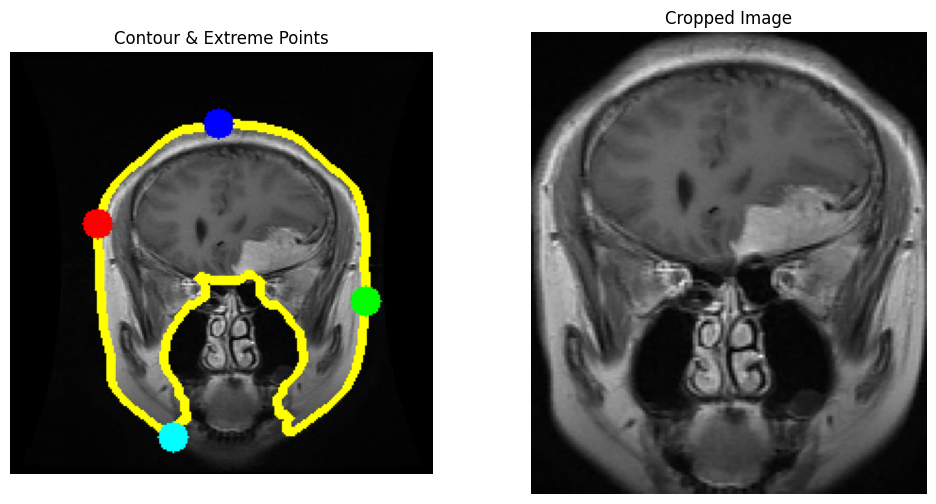

In [ ]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt

# Load and resize image
img_path = '/content/brain_tumor/meningioma/meningioma/Tr-meTr_0000.jpg'
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

# Crop image and get contour
cropped_img, contour = crop_img(img, add_pixels=0, return_contour=True)

# If contour is found, visualize
if contour is not None:
    extLeft = tuple(contour[contour[:, :, 0].argmin()][0])
    extRight = tuple(contour[contour[:, :, 0].argmax()][0])
    extTop = tuple(contour[contour[:, :, 1].argmin()][0])
    extBot = tuple(contour[contour[:, :, 1].argmax()][0])

    img_cnt = cv2.drawContours(img.copy(), [contour], -1, (0, 255, 255), 4)
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # Show images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_pnt, cv2.COLOR_BGR2RGB))
    plt.title("Contour & Extreme Points")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.axis("off")
    plt.show()
else:
    print("No contour found. Skipping visualization.")


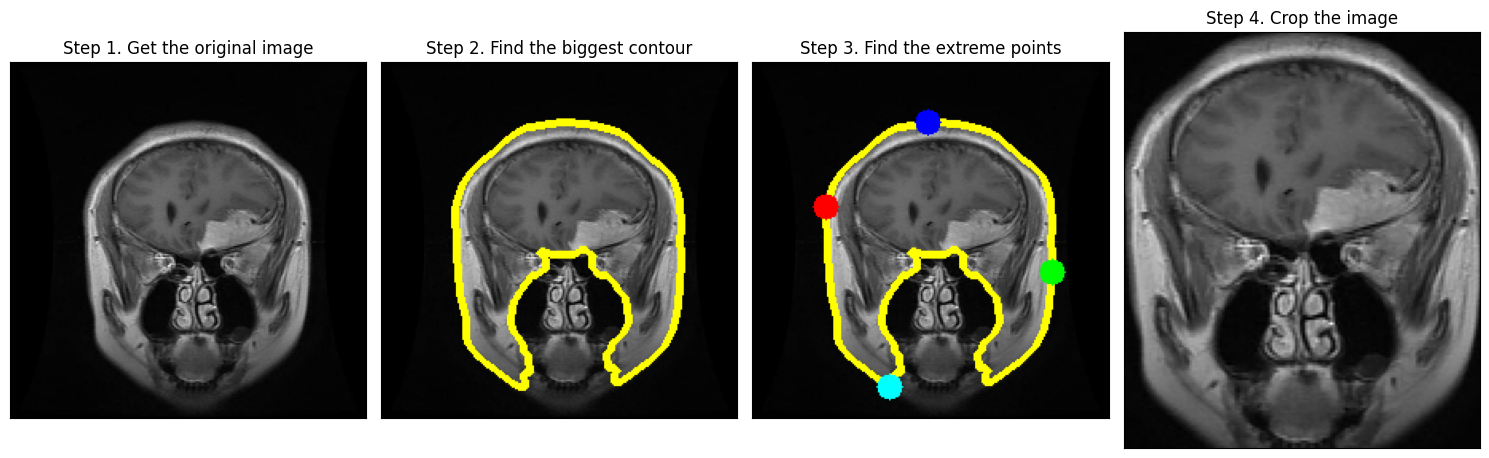

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(141)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')

plt.subplot(142)
plt.imshow(cv2.cvtColor(img_cnt, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')

plt.subplot(143)
plt.imshow(cv2.cvtColor(img_pnt, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')

plt.subplot(144)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))  # cropped_img from earlier
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

plt.tight_layout()
plt.show()


In [ ]:
import zipfile
import os

# List of zip file paths (Make sure these are correctly named)
zip_paths = [
    '/content/drive/MyDrive/brain_tumour/testing/glioma/glioma-20250408T201003Z-001.zip',
    '/content/drive/MyDrive/brain_tumour/testing/meningioma/meningioma-20250408T201344Z-001.zip',
    '/content/drive/MyDrive/brain_tumour/testing/notumor/notumor-20250408T201736Z-001.zip',
    '/content/drive/MyDrive/brain_tumour/testing/pituitary/pituitary-20250408T201910Z-001.zip'
]

# Matching extract directories — use consistent names (no space in folder names)
extract_dirs = [
    '/content/brain_tumor/glioma',
    '/content/brain_tumor/meningioma',
    '/content/brain_tumor/notumor',
    '/content/brain_tumor/pituitary'
]

# Unzip each file to its corresponding directory
for zip_file, extract_to in zip(zip_paths, extract_dirs):
    try:
        print(f"📦 Extracting {zip_file} → {extract_to}")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("✅ Done\n")
    except Exception as e:
        print(f"❌ Error extracting {zip_file}: {e}\n")


📦 Extracting /content/drive/MyDrive/brain_tumour/testing/glioma/glioma-20250408T201003Z-001.zip → /content/brain_tumor/glioma
✅ Done

📦 Extracting /content/drive/MyDrive/brain_tumour/testing/meningioma/meningioma-20250408T201344Z-001.zip → /content/brain_tumor/meningioma
✅ Done

📦 Extracting /content/drive/MyDrive/brain_tumour/testing/notumor/notumor-20250408T201736Z-001.zip → /content/brain_tumor/notumor
✅ Done

📦 Extracting /content/drive/MyDrive/brain_tumour/testing/pituitary/pituitary-20250408T201910Z-001.zip → /content/brain_tumor/pituitary
✅ Done



In [ ]:
source_test_root = "/content/brain_tumor_testing"
cropped_test_root = "/content/drive/My Drive/brain_tumour/cropped/testing"


In [ ]:
import shutil
import os

# Paths
wrong_path = '/content/drive/MyDrive/brain_tumour/cropped/testing'
correct_path = '/content/drive/MyDrive/brain_tumour/cropped/Testing'

# Move contents from wrong_path to correct_path
if os.path.exists(wrong_path):
    for label in os.listdir(wrong_path):
        src = os.path.join(wrong_path, label)
        dst = os.path.join(correct_path, label)
        if os.path.exists(dst):
            print(f"✅ {label} already exists in the correct folder.")
        else:
            print(f"📦 Moving {label} → {dst}")
            shutil.move(src, dst)
    # Optionally, remove the old lowercase folder
    os.rmdir(wrong_path)
    print("✅ Fixed! Moved everything from 'testing' → 'Testing'")
else:
    print("❌ Folder '/testing' not found — nothing to fix.")


📦 Moving meningioma → /content/drive/MyDrive/brain_tumour/cropped/Testing/meningioma
📦 Moving glioma → /content/drive/MyDrive/brain_tumour/cropped/Testing/glioma
📦 Moving pituitary → /content/drive/MyDrive/brain_tumour/cropped/Testing/pituitary
📦 Moving notumor → /content/drive/MyDrive/brain_tumour/cropped/Testing/notumor
📦 Moving .ipynb_checkpoints → /content/drive/MyDrive/brain_tumour/cropped/Testing/.ipynb_checkpoints
✅ Fixed! Moved everything from 'testing' → 'Testing'


In [ ]:
import zipfile
import os

# Paths to your original test zips
zip_paths = {
    'glioma': '/content/drive/MyDrive/brain_tumour/testing/glioma/glioma-20250408T201003Z-001.zip',
    'meningioma': '/content/drive/MyDrive/brain_tumour/testing/meningioma/meningioma-20250408T201344Z-001.zip',
    'notumor': '/content/drive/MyDrive/brain_tumour/testing/notumor/notumor-20250408T201736Z-001.zip',
    'pituitary': '/content/drive/MyDrive/brain_tumour/testing/pituitary/pituitary-20250408T201910Z-001.zip'
}

# Extract them to /content/brain_tumor_testing
for label, zip_file in zip_paths.items():
    extract_to = f"/content/brain_tumor_testing/{label}"
    os.makedirs(extract_to, exist_ok=True)

    try:
        print(f"📦 Extracting {zip_file} → {extract_to}")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ Extracted {label}\n")
    except Exception as e:
        print(f"❌ Failed to extract {label}: {e}")


📦 Extracting /content/drive/MyDrive/brain_tumour/testing/glioma/glioma-20250408T201003Z-001.zip → /content/brain_tumor_testing/glioma
✅ Extracted glioma

📦 Extracting /content/drive/MyDrive/brain_tumour/testing/meningioma/meningioma-20250408T201344Z-001.zip → /content/brain_tumor_testing/meningioma
✅ Extracted meningioma

📦 Extracting /content/drive/MyDrive/brain_tumour/testing/notumor/notumor-20250408T201736Z-001.zip → /content/brain_tumor_testing/notumor
✅ Extracted notumor

📦 Extracting /content/drive/MyDrive/brain_tumour/testing/pituitary/pituitary-20250408T201910Z-001.zip → /content/brain_tumor_testing/pituitary
✅ Extracted pituitary



In [ ]:
import cv2
from tqdm import tqdm

def crop_images(input_dir, output_dir):
    if not os.path.exists(input_dir):
        print(f"❌ Input directory does not exist: {input_dir}")
        return

    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Cropping: {input_dir} → {output_dir}")

    for file in tqdm(os.listdir(input_dir)):
        file_path = os.path.join(input_dir, file)
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                image = cv2.imread(file_path)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                    cropped = image[y:y+h, x:x+w]
                    cv2.imwrite(os.path.join(output_dir, file), cropped)
            except Exception as e:
                print(f"⚠️ Skipped {file}: {e}")

# Labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Crop test images
for label in labels:
    input_dir = f"/content/brain_tumor_testing/{label}/{label}"  # based on zip content structure
    output_dir = f"/content/drive/MyDrive/brain_tumour/cropped/Testing/{label}"
    crop_images(input_dir, output_dir)


📁 Cropping: /content/brain_tumor_testing/glioma/glioma → /content/drive/MyDrive/brain_tumour/cropped/Testing/glioma


100%|██████████| 1321/1321 [00:19<00:00, 67.47it/s]


📁 Cropping: /content/brain_tumor_testing/meningioma/meningioma → /content/drive/MyDrive/brain_tumour/cropped/Testing/meningioma


100%|██████████| 1339/1339 [00:19<00:00, 68.68it/s]


📁 Cropping: /content/brain_tumor_testing/notumor/notumor → /content/drive/MyDrive/brain_tumour/cropped/Testing/notumor


100%|██████████| 1595/1595 [00:20<00:00, 78.98it/s]


📁 Cropping: /content/brain_tumor_testing/pituitary/pituitary → /content/drive/MyDrive/brain_tumour/cropped/Testing/pituitary


100%|██████████| 1457/1457 [00:24<00:00, 60.26it/s]


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Define the crop function
def crop_img(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return image[y:y+h, x:x+w]
    else:
        return image

# Set paths and image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
raw_training_root = "/content/brain_tumor"
cropped_train_root = "/content/brain_tumor_cropped/training"
IMG_SIZE = 256

# Crop and save training images
def safe_crop_and_save(input_dir, output_dir):
    if not os.path.exists(input_dir):
        print(f"❌ Input directory does not exist: {input_dir}")
        return

    os.makedirs(output_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(input_dir), desc=f"Cropping {input_dir}"):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"⚠️ Could not read image: {img_path}")
            continue

        try:
            cropped_img = crop_img(image)
            resized_img = cv2.resize(cropped_img, (IMG_SIZE, IMG_SIZE))
            save_path = os.path.join(output_dir, img_name)
            cv2.imwrite(save_path, resized_img)
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")

# Run cropping for training data
for label in labels:
    input_dir = os.path.join(raw_training_root, label, label)
    output_dir = os.path.join(cropped_train_root, label)
    safe_crop_and_save(input_dir, output_dir)

# =====================
# Load preprocessed training images
# =====================
x_train, y_train = [], []
image_size = 200

for label in labels:
    train_dir = os.path.join(cropped_train_root, label)

    if not os.path.exists(train_dir):
        print(f"❌ Training folder not found for: {label}")
        continue

    for file in tqdm(os.listdir(train_dir), desc=f"Loading training {label}"):
        file_path = os.path.join(train_dir, file)
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        image = cv2.imread(file_path, 0)
        if image is None:
            print(f"⚠️ Could not read {file_path}")
            continue

        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))

# Convert to NumPy arrays and normalize
x_train = np.array(x_train, dtype=np.float32) / 255.0
y_train = np.array(y_train)

# Dataset info
print("\n✅ Training dataset loaded successfully:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


Cropping /content/brain_tumor/glioma/glioma: 100%|██████████| 1321/1321 [00:05<00:00, 243.44it/s]
Cropping /content/brain_tumor/meningioma/meningioma: 100%|██████████| 1339/1339 [00:04<00:00, 276.54it/s]
Cropping /content/brain_tumor/notumor/notumor: 100%|██████████| 1595/1595 [00:05<00:00, 274.12it/s]
Cropping /content/brain_tumor/pituitary/pituitary: 100%|██████████| 1457/1457 [00:06<00:00, 219.50it/s]
Loading training pituitary: 100%|██████████| 1457/1457 [00:02<00:00, 677.27it/s]



✅ Training dataset loaded successfully:
x_train shape: (5712, 200, 200, 3)
y_train shape: (5712,)


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Define crop function
def crop_img(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return image[y:y+h, x:x+w]
    else:
        return image

# Set paths and image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
raw_testing_root = "/content/brain_tumor_testing"
cropped_test_root = "/content/brain_tumor_cropped/testing"
IMG_SIZE = 256

# Crop and save testing images
def safe_crop_and_save(input_dir, output_dir):
    if not os.path.exists(input_dir):
        print(f"❌ Input directory does not exist: {input_dir}")
        return

    os.makedirs(output_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(input_dir), desc=f"Cropping {input_dir}"):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"⚠️ Could not read image: {img_path}")
            continue

        try:
            cropped_img = crop_img(image)
            resized_img = cv2.resize(cropped_img, (IMG_SIZE, IMG_SIZE))
            save_path = os.path.join(output_dir, img_name)
            cv2.imwrite(save_path, resized_img)
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")

# Run cropping for testing data
for label in labels:
    input_dir = os.path.join(raw_testing_root, label, label)
    output_dir = os.path.join(cropped_test_root, label)
    safe_crop_and_save(input_dir, output_dir)

# =====================
# Load preprocessed testing images
# =====================
x_test, y_test = [], []
image_size = 200

for label in labels:
    test_dir = os.path.join(cropped_test_root, label)

    if not os.path.exists(test_dir):
        print(f"❌ Testing folder not found for: {label}")
        continue

    for file in tqdm(os.listdir(test_dir), desc=f"Loading testing {label}"):
        file_path = os.path.join(test_dir, file)
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        image = cv2.imread(file_path, 0)
        if image is None:
            print(f"⚠️ Could not read {file_path}")
            continue

        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

# Convert to NumPy arrays and normalize
x_test = np.array(x_test, dtype=np.float32) / 255.0
y_test = np.array(y_test)

# Dataset info
print("\n✅ Testing dataset loaded successfully:")
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


Cropping /content/brain_tumor_testing/glioma/glioma: 100%|██████████| 1321/1321 [00:03<00:00, 395.81it/s]
Cropping /content/brain_tumor_testing/meningioma/meningioma: 100%|██████████| 1339/1339 [00:03<00:00, 375.36it/s]
Cropping /content/brain_tumor_testing/notumor/notumor: 100%|██████████| 1595/1595 [00:03<00:00, 456.27it/s]
Cropping /content/brain_tumor_testing/pituitary/pituitary: 100%|██████████| 1457/1457 [00:06<00:00, 213.90it/s]
Loading testing pituitary: 100%|██████████| 1457/1457 [00:02<00:00, 487.80it/s]



✅ Testing dataset loaded successfully:
x_test shape: (5712, 200, 200, 3)
y_test shape: (5712,)


Processing /content/brain_tumor/glioma/glioma: 100%|██████████| 1321/1321 [00:03<00:00, 367.12it/s]
Processing /content/brain_tumor/meningioma/meningioma: 100%|██████████| 1339/1339 [00:05<00:00, 241.94it/s]
Processing /content/brain_tumor/notumor/notumor: 100%|██████████| 1595/1595 [00:03<00:00, 489.20it/s]
Processing /content/brain_tumor/pituitary/pituitary: 100%|██████████| 1457/1457 [00:04<00:00, 331.17it/s]
Loading pituitary: 100%|██████████| 1457/1457 [00:00<00:00, 1467.10it/s]



x_train shape: (5712, 200, 200, 3)
y_train shape: (5712,)


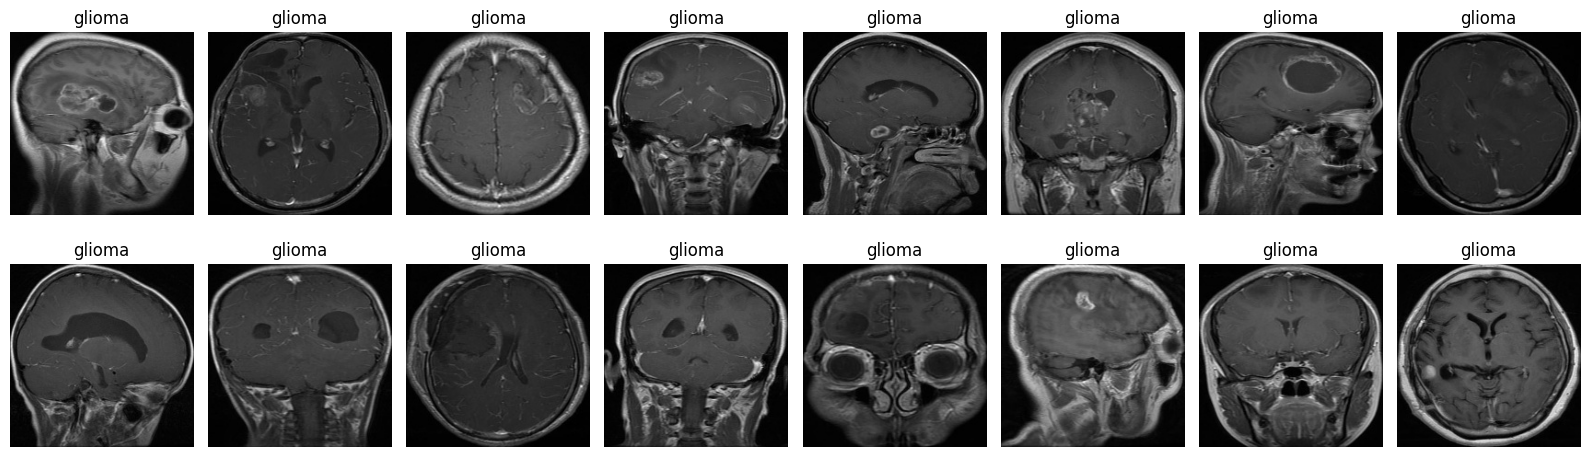

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- CONFIG ---
IMG_SIZE = 200
CROPPED_TRAIN_DIR = "/content/brain_tumor_cropped/training"
ORIGINAL_TRAIN_DIR = "/content/brain_tumor"
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# --- STEP 1: Cropping function ---
def crop_img(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return image  # No contour found

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cropped = image[y:y+h, x:x+w]
    return cropped

# --- STEP 2: Safe crop and save ---
def safe_crop_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(input_dir), desc=f"Processing {input_dir}"):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"⚠️ Could not read image: {img_path}")
            continue

        try:
            cropped_img = crop_img(image)
            resized_img = cv2.resize(cropped_img, (IMG_SIZE, IMG_SIZE))
            save_path = os.path.join(output_dir, img_name)
            cv2.imwrite(save_path, resized_img)
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")

# --- STEP 3: Crop and save all training images ---
for label in labels:
    input_path = os.path.join(ORIGINAL_TRAIN_DIR, label, label)
    output_path = os.path.join(CROPPED_TRAIN_DIR, label)
    safe_crop_and_save(input_path, output_path)

# --- STEP 4: Load processed images into NumPy arrays ---
x_train = []
y_train = []

for label in labels:
    path = os.path.join(CROPPED_TRAIN_DIR, label)
    if not os.path.exists(path):
        print(f"❌ Directory not found: {path}")
        continue

    for file in tqdm(os.listdir(path), desc=f"Loading {label}"):
        file_path = os.path.join(path, file)
        if not os.path.isfile(file_path):
            continue

        img = cv2.imread(file_path)
        if img is None:
            print(f"⚠️ Failed to read: {file_path}")
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        x_train.append(img)
        y_train.append(labels.index(label))

x_train = np.array(x_train, dtype=np.float32) / 255.0
y_train = np.array(y_train)

print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# --- STEP 5: Visualization ---
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(x_train):
        break
    img = x_train[i]
    label_idx = y_train[i]
    ax.imshow(img)
    ax.set_title(labels[label_idx])
    ax.axis('off')

plt.tight_layout()
plt.show()


✅ Saved 15 images to /content/sample_images


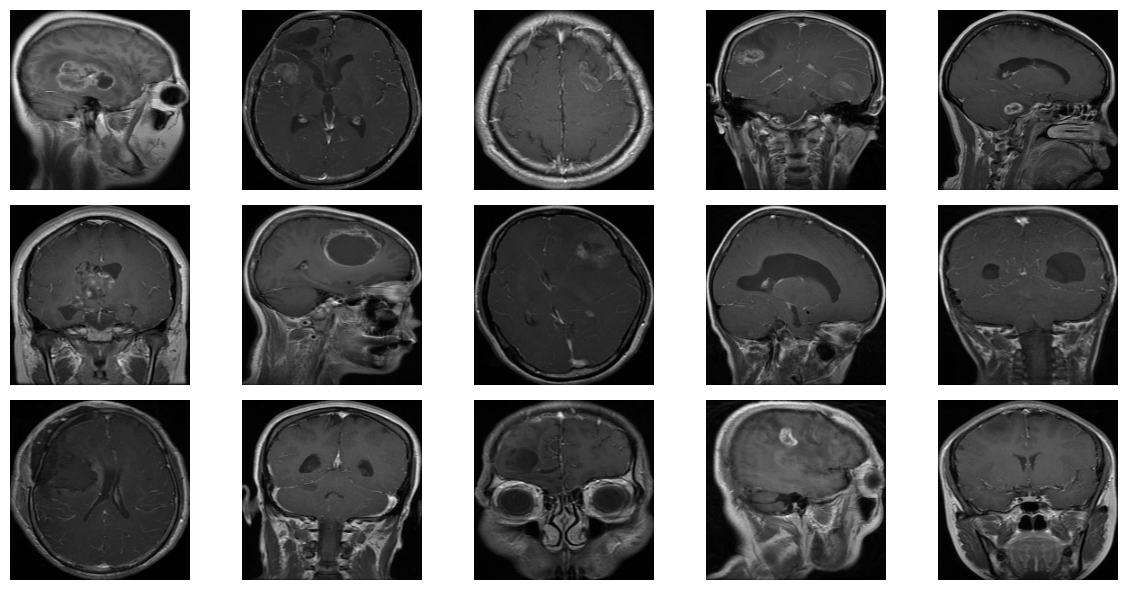

✅ Saved grid image to /content/sample_images/grid_display.png


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Output directory to save images
output_dir = "/content/sample_images"
os.makedirs(output_dir, exist_ok=True)

# Select 15 images (change the range if needed)
selected_images = x_train[:15]

# Save each image
for idx, img in enumerate(selected_images):
    # Convert to BGR if needed (OpenCV writes in BGR)
    bgr_img = (img * 255).astype(np.uint8)
    save_path = os.path.join(output_dir, f"image_{idx+1}.png")
    cv2.imwrite(save_path, cv2.cvtColor(bgr_img, cv2.COLOR_RGB2BGR))

print(f"✅ Saved {len(selected_images)} images to {output_dir}")

# Save the plot grid
fig, axes = plt.subplots(3, 5, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i])
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "grid_display.png"))
plt.show()

print(f"✅ Saved grid image to {output_dir}/grid_display.png")



In [ ]:
import os

path = "/content/brain_tumor_cropped/training" # Change the path to point to the folder in colab

print(os.listdir(path)) # This will list the content of the path

data_path = "/content/drive/MyDrive/brain_tumor_cropped/training"

import os
import cv2
import numpy as np

# ✅ CHANGE THIS to where your folders actually are
data_path = "/content/brain_tumor_cropped/training"

# ✅ Check the path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Path does not exist: {data_path}")

# ✅ Subfolder names (must match folders inside data_path)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

x = []
y = []

for idx, label in enumerate(classes):
    folder = os.path.join(data_path, label)
    if not os.path.exists(folder):
        print(f"Skipping missing folder: {folder}")
        continue
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable image: {img_path}")
            continue
        img = cv2.resize(img, (200, 200))
        x.append(img)
        y.append(idx)

# Convert to arrays
x = np.array(x)
y = np.array(y)

# Show the final shape
print("Final x shape:", x.shape)



['glioma', 'meningioma', 'notumor', 'pituitary']
Final x shape: (5712, 200, 200, 3)


Loading pituitary: 100%|██████████| 1457/1457 [00:00<00:00, 1957.84it/s]


✅ Loaded dataset
x_train shape: (4569, 200, 200, 3)
✅ 20 augmented images saved in 'preview_2' folder


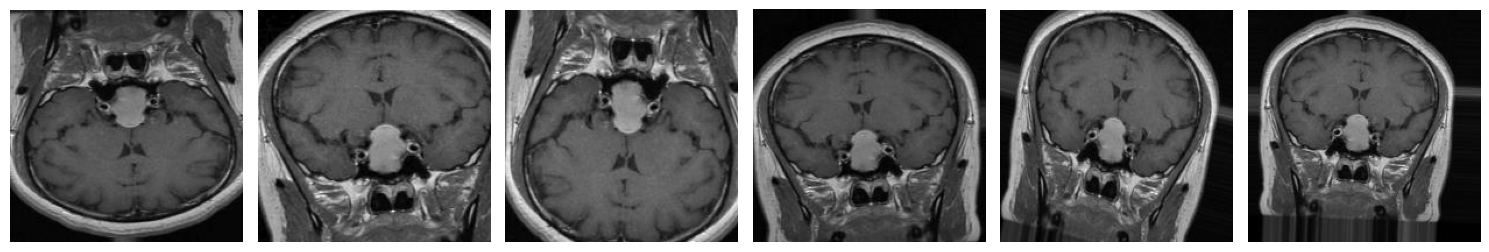

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load dataset
image_size = 200
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_path = "/content/brain_tumor_cropped/training"
x_train = []
y_train = []

for idx, label in enumerate(labels):
    folder = os.path.join(data_path, label)
    if not os.path.exists(folder):
        print(f"❌ Folder not found: {folder}")
        continue

    for file in tqdm(os.listdir(folder), desc=f"Loading {label}"):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Could not read {img_path}")
            continue
        img = cv2.resize(img, (image_size, image_size))
        x_train.append(img)
        y_train.append(idx)

# Convert and normalize
x_train = np.array(x_train, dtype=np.float32) / 255.0
y_train = np.array(y_train)

# Shuffle and one-hot encode
x_train, y_train = shuffle(x_train, y_train, random_state=42)
y_train = to_categorical(y_train)

# Optional: Split for validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("✅ Loaded dataset")
print("x_train shape:", x_train.shape)

# Step 2: Augment and save preview images
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# Create output folder
output_folder = 'preview_2'
os.makedirs(output_folder, exist_ok=True)

# Pick the first image and denormalize for saving
x = x_train[0]
x = (x * 255).astype(np.uint8)
x = np.expand_dims(x, axis=0)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir=output_folder,
                               save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

print("✅ 20 augmented images saved in 'preview_2' folder")

# Step 3: Show a few augmented images
preview_images = sorted(os.listdir(output_folder))[:6]
fig, axes = plt.subplots(1, 6, figsize=(15, 4))
for ax, img_name in zip(axes, preview_images):
    img = cv2.imread(os.path.join(output_folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


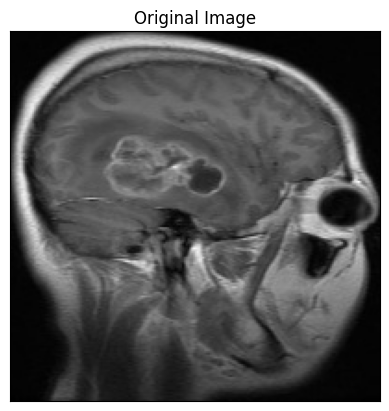

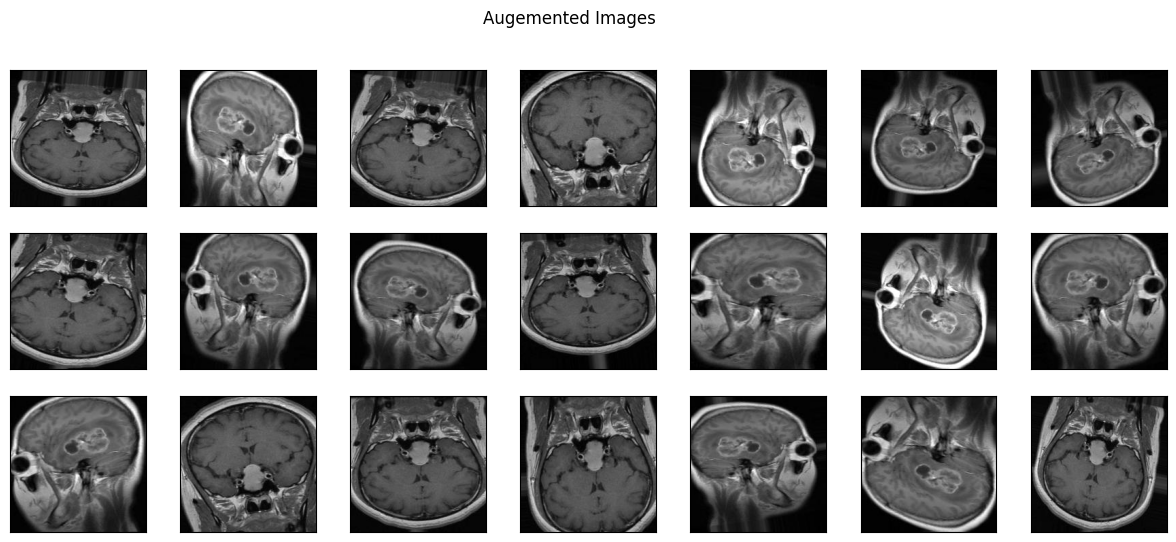

In [ ]:
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_2/'):
    img = cv2.imread('preview_2/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Set image size and input shape
IMG_SIZE = (200, 200)
input_shape = IMG_SIZE + (3,)

# Load ResNet50 base model without the top classification layer
conv_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

# Optionally: Make all layers trainable (fine-tuning)
for layer in conv_base.layers:
    layer.trainable = True  # You can set to False if you want to freeze the base

# Add custom classification head on top
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(
    x)  # 4 classes: glioma, meningioma, notumor, pituitary

# Build the full model
model = Model(inputs=conv_base.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 206, 206, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 50, 50, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 50, 50, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 50, 50, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau # Import necessary classes

# Changed the filepath to end with '.keras'
callbacks = [ModelCheckpoint('best_model.keras', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
train_len = len(x_train)
val_len = len(x_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
5712
-----------Validation Data length-----------------
1143


In [ ]:
!pip install tensorflow


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Parameters
IMG_SIZE = 200
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Try common possible paths
POSSIBLE_PATHS = ["/content/drive/MyDrive/brain_tumour/cropped/Training"



]

DATA_PATH = None
for path in POSSIBLE_PATHS:
    if os.path.exists(path):
        DATA_PATH = path
        break

if DATA_PATH is None:
    raise FileNotFoundError("❌ Dataset folder not found. Please upload or correct the dataset path.")

print("✅ Dataset found at:", DATA_PATH)

# Load and preprocess
x_data, y_data = [], []
for idx, label in enumerate(CLASSES):
    class_dir = os.path.join(DATA_PATH, label)
    if not os.path.exists(class_dir):
        print(f"⚠️ Folder not found: {class_dir}")
        continue
    print(f"📁 Loading {label}...")
    for file in tqdm(os.listdir(class_dir)):
        file_path = os.path.join(class_dir, file)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            x_data.append(img)
            y_data.append(idx)

# Check if any data was loaded
if len(x_data) == 0:
    raise ValueError("❌ No images were loaded. Check your dataset path and folder structure.")

# Convert and normalize
x_data = np.array(x_data, dtype=np.float32) / 255.0
y_data = to_categorical(np.array(y_data), num_classes=len(CLASSES))

# Shuffle and split
x_data, y_data = shuffle(x_data, y_data, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(f"✅ Loaded {len(x_train)} training images and {len(x_val)} validation images.")


✅ Dataset found at: /content/drive/MyDrive/brain_tumour/cropped/Training
📁 Loading glioma...


100%|██████████| 1321/1321 [00:28<00:00, 45.93it/s] 


📁 Loading meningioma...


100%|██████████| 1339/1339 [00:30<00:00, 44.53it/s] 


📁 Loading notumor...


100%|██████████| 1595/1595 [00:37<00:00, 42.16it/s] 


📁 Loading pituitary...


100%|██████████| 1457/1457 [00:34<00:00, 41.87it/s] 


✅ Loaded 4569 training images and 1143 validation images.


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Parameters
IMG_SIZE = 128  # smaller image size for faster training
BATCH_SIZE = 16
EPOCHS = 3
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
LIMIT_SAMPLES = 200  # limit per class for fast test run

# Locate dataset
POSSIBLE_PATHS = ["/content/drive/MyDrive/brain_tumour/cropped/Training"
]
DATA_PATH = next((p for p in POSSIBLE_PATHS if os.path.exists(p)), None)
if not DATA_PATH:
    raise FileNotFoundError("Dataset folder not found.")

# Load & preprocess data
x_data, y_data = [], []
for idx, label in enumerate(CLASSES):
    folder = os.path.join(DATA_PATH, label)
    files = os.listdir(folder)[:LIMIT_SAMPLES]  # Limit samples per class
    for file in tqdm(files, desc=f"Loading {label}"):
        img = cv2.imread(os.path.join(folder, file))
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            x_data.append(img)
            y_data.append(idx)

# Preprocess
x_data = np.array(x_data, dtype=np.float32) / 255.0
y_data = to_categorical(np.array(y_data), num_classes=len(CLASSES))

# Split
x_data, y_data = shuffle(x_data, y_data, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Augmentation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

# Build model with frozen ResNet50 base
base_model = ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # Freeze all layers

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# Train (short + fast)
print("🚀 Starting fast training...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Loading pituitary: 100%|██████████| 200/200 [00:17<00:00, 11.38it/s]


🚀 Starting fast training...
Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.2064 - loss: 1.5653
Epoch 1: val_loss improved from inf to 1.33063, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.2073 - loss: 1.5634 - val_accuracy: 0.3438 - val_loss: 1.3306 - learning_rate: 0.0010
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.3050 - loss: 1.3751
Epoch 2: val_loss improved from 1.33063 to 1.26857, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3056 - loss: 1.3744 - val_accuracy: 0.5688 - val_loss: 1.2686 - learning_rate: 0.0010
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4128 - loss: 1.2732
Epoch 3: val_loss improved from 1.26857 to 1.21547, saving model to best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4130 - loss: 1.2731 - val_accuracy: 0.6000 - val_loss: 1.2155 - learning_rate: 0.0010
Restoring model weights from the end of the best 

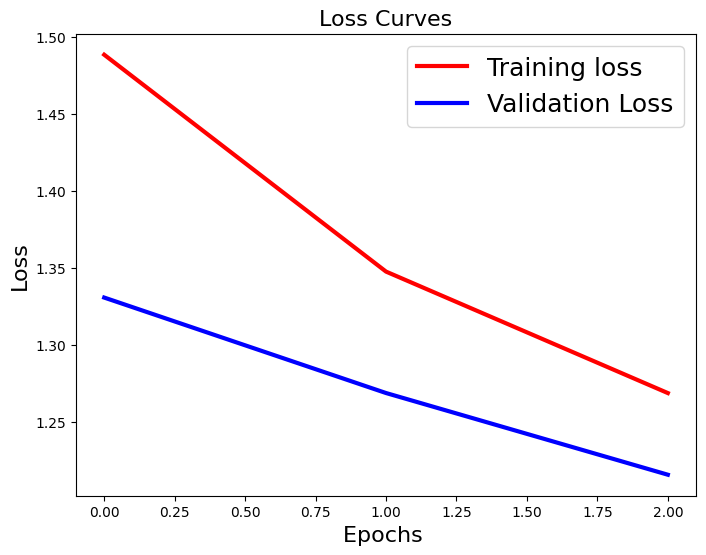

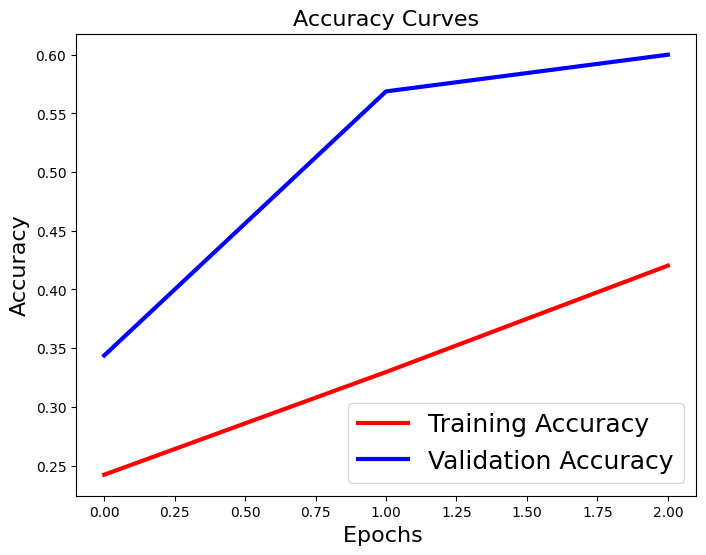

In [ ]:
import matplotlib.pyplot as plt # Import the necessary module

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load your previously saved model (in .keras format)
model = load_model('best_model.keras')  # or replace with your actual path if needed

# Save it to Drive using the new format
model.save('/content/drive/My Drive/brain_tumour/modelres50.keras')  # modern format

# Load it again
model = load_model('/content/drive/My Drive/brain_tumour/modelres50.keras')

# Re-compile if you want to evaluate/train further
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# ✅ If not already done, define or load your test data
# Example (if you want to split from the full dataset again):
from sklearn.model_selection import train_test_split

# Assuming x_data, y_data are already prepared and normalized
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# ✅ Load model (either from .keras or .h5)
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/brain_tumour/modelres50.keras')

# ✅ Compile model (required before evaluate if loading)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Now safely evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {acc*100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5694 - loss: 1.2308
Test Accuracy: 60.00%


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report

# Ensure model is compiled and x_test, y_test are defined and preprocessed
# Example if needed:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Predict class indices
y_pred = np.argmax(model.predict(x_test), axis=1)

# ✅ True class indices
y_true = np.argmax(y_test, axis=1)

# ✅ Display classification report
print(classification_report(y_true, y_pred, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
              precision    recall  f1-score   support

      glioma       0.43      0.97      0.60        38
  meningioma       0.84      0.88      0.86        42
     notumor       0.73      0.58      0.65        38
   pituitary       0.00      0.00      0.00        42

    accuracy                           0.60       160
   macro avg       0.50      0.61      0.53       160
weighted avg       0.50      0.60      0.52       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step


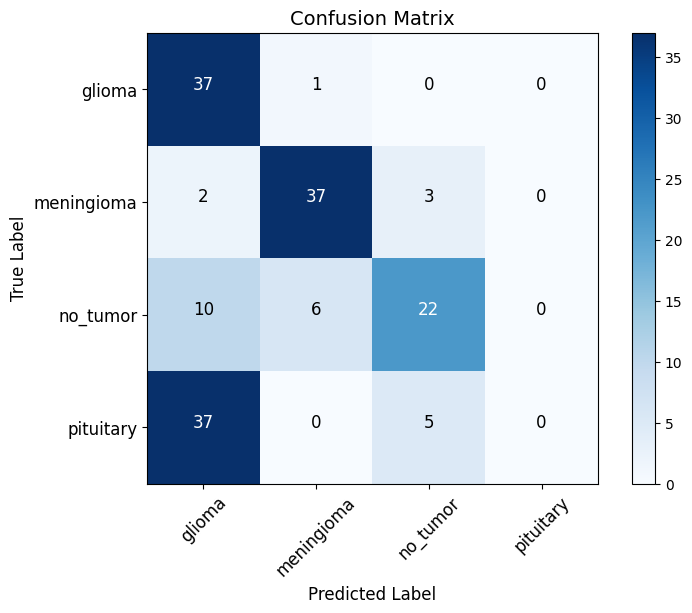

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# ✅ Predict the values from the test set
pred_Y = model.predict(x_test, batch_size=8, verbose=1)

# ✅ Convert predictions and labels to class indices
Y_pred_classes = np.argmax(pred_Y, axis=1)
Y_true_classes = np.argmax(y_test, axis=1)

# ✅ Compute confusion matrix
confusion_mtx = confusion_matrix(Y_true_classes, Y_pred_classes)

# ✅ Plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.grid(False)
    plt.show()

# ✅ Class names
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# ✅ Plot
plot_confusion_matrix(confusion_mtx, classes=class_names)


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step


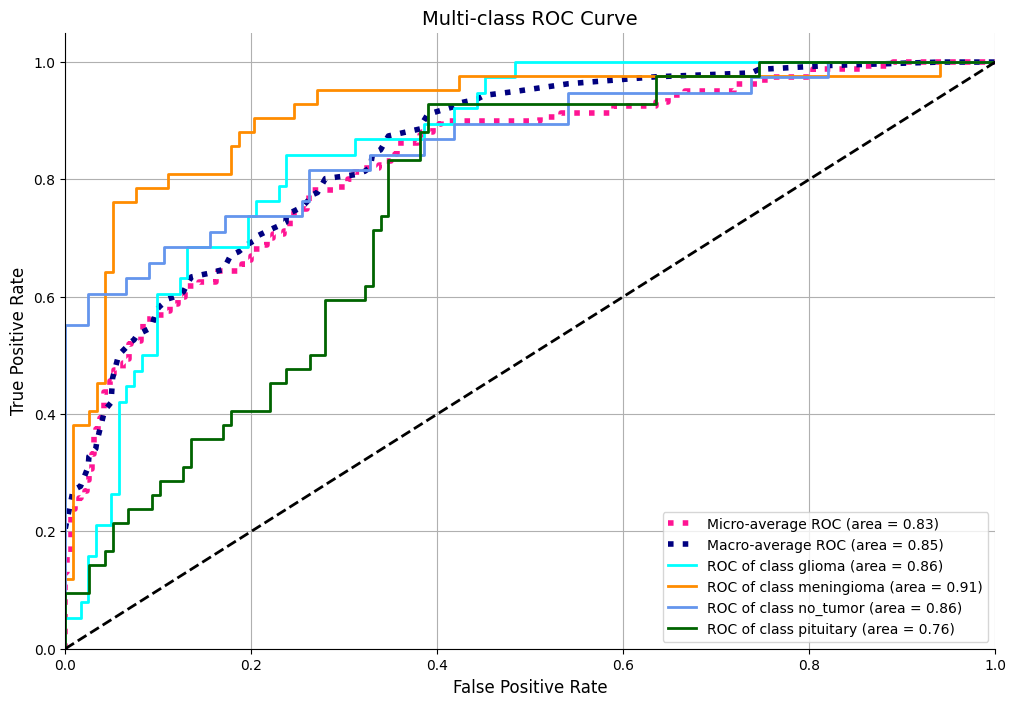

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import seaborn as sns

# If you're using Jupyter/Colab (optional in scripts):
# %matplotlib inline  ← REMOVE this line if not in a notebook

# Ensure `y_test` is a NumPy array
y_test = np.array(y_test)

# Number of classes
n_classes = y_test.shape[1]

# Predict probabilities
pred_Y = model.predict(x_test, batch_size=16, verbose=1)

# ROC computation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

# Micro ROC
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Macro ROC
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Per-class ROC
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
sns.despine()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


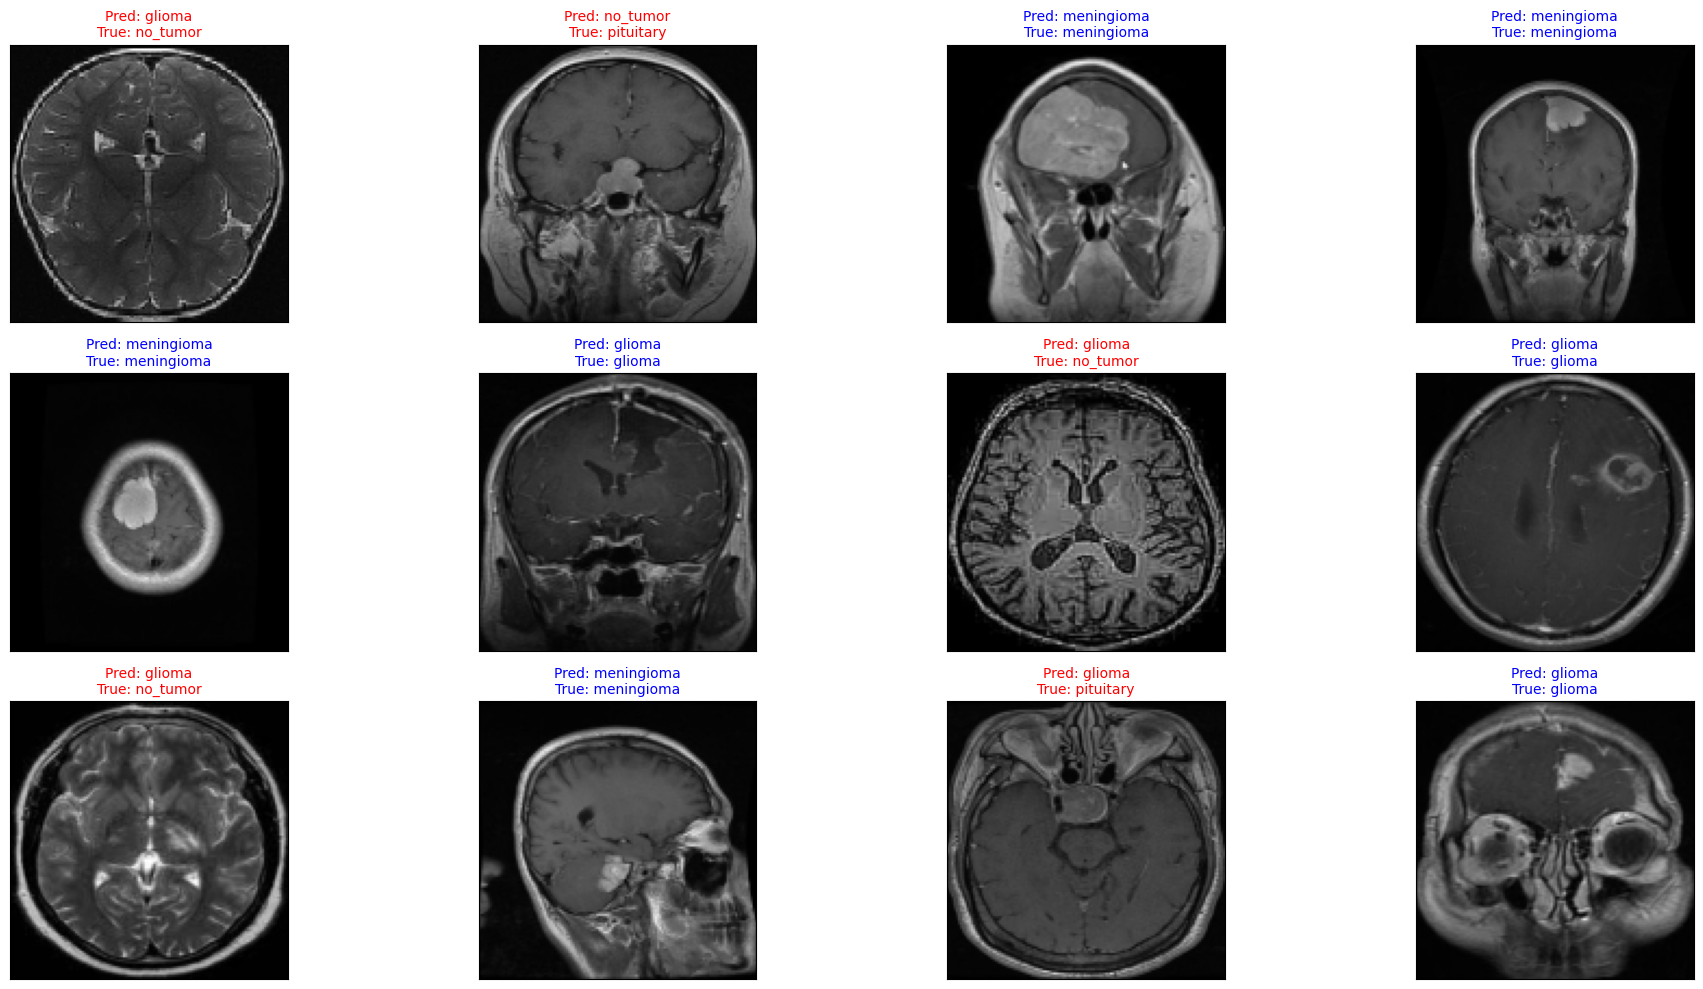

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test set
y_hat = model.predict(x_test)

# Define text labels
target_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Plot random 12 test samples with prediction vs ground truth
fig = plt.figure(figsize=(20, 10))
for i, idx in enumerate(np.random.choice(len(x_test), size=12, replace=False)):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])

    # Show the image
    ax.imshow(x_test[idx])  # x_test is assumed to be normalized and RGB

    # Get predicted and true label indices
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])

    # Set title with color
    ax.set_title(f"Pred: {target_labels[pred_idx]}\nTrue: {target_labels[true_idx]}",
                 color=("blue" if pred_idx == true_idx else "red"),
                 fontsize=10)

plt.tight_layout()
plt.show()
